In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
root_path = "../frames/" 
actions = ["boxing", "handwaving", "running", "walking"]  # Carpetas de donde se van a extraer features

## Farneback

In [4]:
# Parámetros de Optical Flow
farneback_params = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# Función para calcular histograma de ángulos con pesos de magnitud
def compute_flow_histogram(prev, next, bins=8):
    flow = cv2.calcOpticalFlowFarneback(prev, next, None, **farneback_params)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hist, _ = np.histogram(ang, bins=bins, range=(0, 2*np.pi), weights=mag)
    hist = hist / (np.sum(hist) + 1e-6)
    return hist

# Acumuladores globales
data = []
labels = []


# Número máximo de personas a procesar por acción
limit =5  # Cambia este valor para procesar más o menos personas

# Recorrer todas las acciones y sus carpetas de personas
for action in actions:
    action_path = os.path.join(root_path, action)
    if not os.path.exists(action_path):
        print(action_path)
        continue
    
    count = 0  # Contador de personas procesadas
    for person_folder in sorted(os.listdir(action_path)):
        
        if count >= limit:  # Si alcanzamos el límite, rompemos el bucle
            break

        person_path = os.path.join(action_path, person_folder)
        if not os.path.isdir(person_path):
            continue

        frame_files = sorted([f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        features = []
        for i in range(len(frame_files) - 1):
            frame1 = cv2.imread(os.path.join(person_path, frame_files[i]), cv2.IMREAD_GRAYSCALE)
            frame2 = cv2.imread(os.path.join(person_path, frame_files[i+1]), cv2.IMREAD_GRAYSCALE)
            if frame1 is None or frame2 is None:
                continue
            hist = compute_flow_histogram(frame1, frame2)
            features.append(hist)

        if features:
            aggregated = np.mean(features, axis=0)
            data.append(aggregated)
            labels.append(action)

        count += 1  # Incrementamos el contador

    print(f"Procesados {count} personas para la acción '{action}'")

KeyboardInterrupt: 

In [16]:
# Convertir los datos a numpy arrays
X = np.array(data)
y = np.array(labels)

# Dividir los datos en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un clasificador KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = knn.predict(X_test)

# Evaluación: precisión
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Precisión del clasificador KNN: {accuracy * 100:.2f}%")


Precisión del clasificador KNN: 25.00%


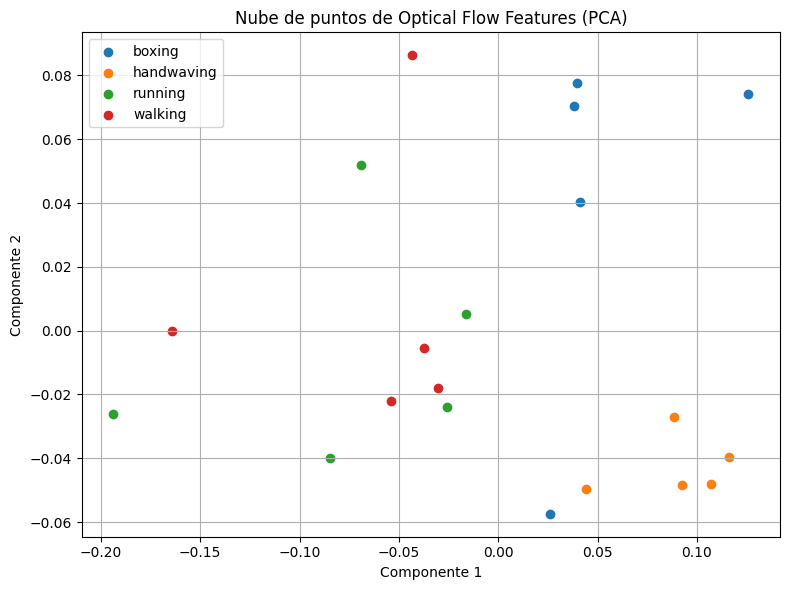

In [ ]:
# Opcional: Proyección de los datos a 2D con PCA para visualización

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Graficar la nube de puntos
plt.figure(figsize=(6, 4))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label)

plt.title("Nube de puntos de Optical Flow Features (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Shi Tomasi y Lucas Kanade

Detectar esquinas usando shi tomasi y luego extraer features con optical flow usando Lucas Kanade


### Definición de params

In [7]:
# Parámetros Shi-Tomasi
shi_tomasi_params = dict(
    maxCorners=100,
    qualityLevel=0.01,
    minDistance=7,
    blockSize=7
)

# Parámetros para calcOpticalFlowPyrLK
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

def compute_sparse_optical_flow_histogram(prev_gray, next_gray, bins=8):
    # Detectar esquinas (Shi-Tomasi)
    prev_pts = cv2.goodFeaturesToTrack(
        prev_gray,
        maxCorners=100,
        qualityLevel=0.3,
        minDistance=7
    )

    # Validación temprana
    if prev_pts is None or len(prev_pts) < 2:
        return None  # No hay suficientes puntos

    # Calcular Optical Flow (Lucas-Kanade piramidal)
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray,
        next_gray,
        prev_pts,
        None
    )

    if next_pts is None or status is None:
        return None  # No se pudo calcular el flujo

    # Filtrar puntos válidos y asegurar forma correcta
    status = status.flatten()
    good_old = prev_pts[status == 1]
    good_new = next_pts[status == 1]

    if len(good_old) < 2 or len(good_new) < 2:
        return None  # Demasiado pocos puntos buenos

    good_old = good_old.reshape(-1, 2)
    good_new = good_new.reshape(-1, 2)

    # Calcular desplazamientos
    dx = good_new[:, 0] - good_old[:, 0]
    dy = good_new[:, 1] - good_old[:, 1]

    # Magnitud y ángulo
    mag, ang = cv2.cartToPolar(dx, dy)

    # Histograma de ángulos, ponderado por la magnitud del movimiento
    hist, _ = np.histogram(ang, bins=bins, range=(0, 2 * np.pi), weights=mag)
    hist = hist / (np.sum(hist) + 1e-6)  # Normalización

    return hist



### Extraer features
*No es necesario ejecutar si ya tienes el archivo con los features extraídos*

In [ ]:
"""
data = []
labels = []

# Recorrer todas las acciones y sus subcarpetas
for action in actions:
    action_path = os.path.join(root_path, action)
    print(action_path)
    if not os.path.exists(action_path):
        continue
    
    for person_folder in sorted(os.listdir(action_path)):
        
        person_path = os.path.join(action_path, person_folder)
        if not os.path.isdir(person_path):
            continue

        frame_files = sorted([f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        features = []
        for i in range(len(frame_files) - 1):
            frame1 = cv2.imread(os.path.join(person_path, frame_files[i]), cv2.IMREAD_GRAYSCALE)
            frame2 = cv2.imread(os.path.join(person_path, frame_files[i+1]), cv2.IMREAD_GRAYSCALE)
            if frame1 is None or frame2 is None:
                continue

            hist = compute_sparse_optical_flow_histogram(frame1, frame2)

            if hist is None: #En caso no se detectaron esquinas
                continue  # Salta este par de frames

            features.append(hist)

        if features:
            aggregated = np.mean(features, axis=0)
            data.append(aggregated)
            labels.append(action)

    print(f"Procesada la acción '{action}'")

"""

../frames/boxing
Procesada la acción 'boxing'
../frames/handwaving
Procesada la acción 'handwaving'
../frames/running
Procesada la acción 'running'
../frames/walking
Procesada la acción 'walking'


In [ ]:
# Guardar en un archivo
#np.savez("ShiTomasi_LK_extracted.npz", data=data, labels=labels)

In [10]:
# Cargar extracción desde archivo 
loaded = np.load("ShiTomasi_LK_extracted.npz", allow_pickle=True)
data = loaded["data"]
labels = loaded["labels"]

In [11]:
# Convertir los datos a numpy arrays
X = np.array(data)
y = np.array(labels)

# Dividir los datos en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Knn

In [12]:

# Entrenar un clasificador KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = knn.predict(X_test)

# Evaluación: precisión
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Precisión del clasificador KNN: {accuracy * 100:.2f}%")

Precisión del clasificador KNN: 83.75%


### Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8125
              precision    recall  f1-score   support

      boxing       0.96      0.85      0.90        26
  handwaving       0.90      1.00      0.95        18
     running       0.63      0.67      0.65        18
     walking       0.72      0.72      0.72        18

    accuracy                           0.81        80
   macro avg       0.80      0.81      0.80        80
weighted avg       0.82      0.81      0.81        80



### Graficar Puntos con PCA

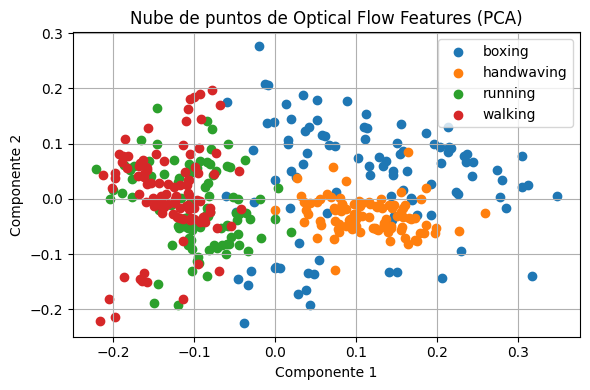

In [16]:
# Proyección de los datos a 2D con PCA para visualización

#Considerar que los datos no se ven asi realmente, aqui reducimos a 2d para que se tenga una idea nomas xd

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(6, 4))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label)

plt.title("Nube de puntos de Optical Flow Features (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()